# Contract Data Exception Checker

### 1. Load Contract Data File from S3

Upload your Excel file containing contract records. This should include columns like Contract_ID, Start_Date, End_Date, and Membership_Level.

In [23]:
# Install AWS SDK
!pip install boto3
!pip install xlsxwriter

import boto3
import pandas as pd
from io import BytesIO
import getpass
from google.colab import files

aws_access_key = getpass.getpass("Enter your AWS Access Key ID: ")
aws_secret_key = getpass.getpass("Enter your AWS Secret Access Key: ")
bucket_name = 'contract-exception-checker'
object_key = 'supplier_contracts.xlsx'  # Example: 'contracts/mock_supplier_contracts_5000.xlsx'

# Connect to S3 and load the Excel file
s3 = boto3.client('s3', aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_key)
response = s3.get_object(Bucket=bucket_name, Key=object_key)
df = pd.read_excel(BytesIO(response['Body'].read()))

Enter your AWS Access Key ID: ··········
Enter your AWS Secret Access Key: ··········


### 2. Convert Dates and Preview the Data

We'll convert the Start_Date and End_Date columns into proper date format so we can run time-based checks. We'll also preview the first few rows of the dataset.

In [24]:
from datetime import datetime

df['Start_Date'] = pd.to_datetime(df['Start_Date'], errors='coerce')
df['End_Date'] = pd.to_datetime(df['End_Date'], errors='coerce')
df.head()

,Supplier_ID,Contract_ID,Product,Price,Start_Date,End_Date,Membership_Level
0,S003,C00001,Bandages,15.60,2024-09-23,2024-09-03,NaN
1,S001,C00002,Bandages,97.33,2025-02-01,2025-07-10,Gold
2,S003,C00003,Stethoscope,62.85,2025-02-14,2025-05-16,Silver
3,S001,C00004,Stethoscope,35.79,2025-04-24,2025-03-12,Bronze
4,S003,C00005,Syringes,10.50,2024-07-17,2024-05-18,Gold


### 3. Identify Expired Contracts

In [25]:
today = pd.to_datetime(datetime.today().date())
expired_contracts = df[df['End_Date'] < today]

print(f"Expired contracts: {len(expired_contracts)}")
expired_contracts.head()

Expired contracts: 3751


,Supplier_ID,Contract_ID,Product,Price,Start_Date,End_Date,Membership_Level
0,S003,C00001,Bandages,15.60,2024-09-23,2024-09-03,NaN
2,S003,C00003,Stethoscope,62.85,2025-02-14,2025-05-16,Silver
3,S001,C00004,Stethoscope,35.79,2025-04-24,2025-03-12,Bronze
4,S003,C00005,Syringes,10.50,2024-07-17,2024-05-18,Gold
5,S004,C00006,Gloves,97.91,2024-08-04,2025-05-23,Silver


### 4. Identify Missing Membership Levels

These are rows where the Membership_Level is either blank or missing.

In [26]:
missing_membership = df[df['Membership_Level'].isnull() | (df['Membership_Level'] == '')]

print(f"Contracts missing membership levels: {len(missing_membership)}")
missing_membership.head()

Contracts missing membership levels: 1297


,Supplier_ID,Contract_ID,Product,Price,Start_Date,End_Date,Membership_Level
0,S003,C00001,Bandages,15.60,2024-09-23,2024-09-03,NaN
6,S002,C00007,Scalpel,94.95,2025-02-08,2025-03-15,NaN
12,S003,C00013,Scalpel,25.35,2025-02-25,2025-11-22,NaN
20,S002,C00021,Scalpel,5.20,2024-10-16,2024-11-20,NaN
21,S003,C00022,Scalpel,71.18,2024-07-23,2025-03-18,NaN


### 5. Identify Duplicate Contract IDs

Sometimes, contract IDs may mistakenly be entered more than once. This flags any duplicates.

In [27]:
duplicate_contracts = df[df.duplicated('Contract_ID', keep=False)]

print(f"Duplicate contract IDs: {len(duplicate_contracts)}")
duplicate_contracts.head()

Duplicate contract IDs: 17


,Supplier_ID,Contract_ID,Product,Price,Start_Date,End_Date,Membership_Level
0,S003,C00001,Bandages,15.60,2024-09-23,2024-09-03,NaN
300,S002,C00001,Syringes,60.42,2025-04-09,2025-01-24,Bronze
600,S003,C00001,Bandages,67.33,2024-06-04,2024-07-26,Silver
900,S002,C00001,Stethoscope,92.13,2024-11-22,2024-09-17,Gold
1200,S004,C00001,Stethoscope,22.16,2025-04-24,2025-12-01,Silver


### 6. Add a Data Quality Score

This step assigns each contract a score out of 100 based on the presence of data quality issues such as expiration, missing membership levels, and duplicate IDs, helping flag contracts that may require review.

In [28]:
df['Data_Quality_Score'] = 100

df.loc[df['End_Date'] < today, 'Data_Quality_Score'] -= 40
df.loc[df['Membership_Level'].isnull() | (df['Membership_Level'] == ''), 'Data_Quality_Score'] -= 30

df['Duplicate_Flag'] = df.duplicated('Contract_ID', keep=False)
df.loc[df['Duplicate_Flag'], 'Data_Quality_Score'] -= 50
df.drop(columns='Duplicate_Flag', inplace=True)

df[['Contract_ID', 'Data_Quality_Score']].head()

,Contract_ID,Data_Quality_Score
0,C00001,-20
1,C00002,100
2,C00003,60
3,C00004,60
4,C00005,60


### 7. Visualize Exceptions with Bar Charts

This helps show how many exceptions occurred per category and by supplier.

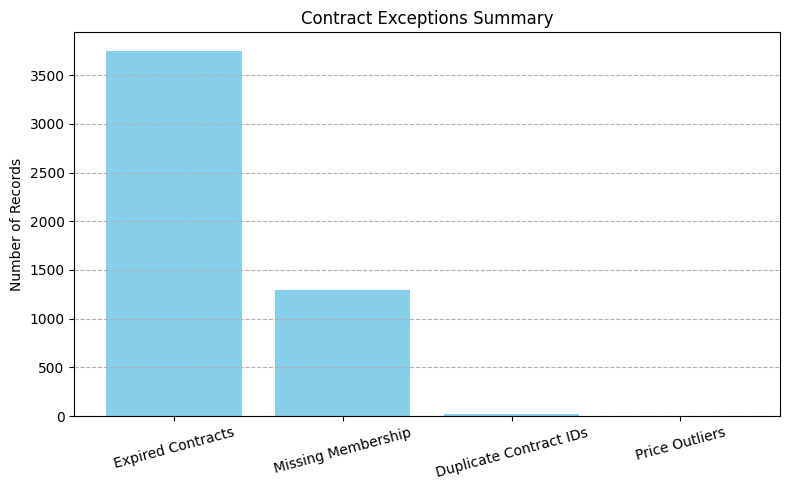

In [29]:
import matplotlib.pyplot as plt

# Exception counts
exceptions = {
    'Expired Contracts': len(expired_contracts),
    'Missing Membership': len(missing_membership),
    'Duplicate Contract IDs': len(duplicate_contracts),
    'Price Outliers': len(price_outliers)
}

plt.figure(figsize=(8, 5))
plt.bar(exceptions.keys(), exceptions.values(), color='skyblue')
plt.title("Contract Exceptions Summary")
plt.ylabel("Number of Records")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

### 8. Export Exception Summary to S3

In [30]:
output = BytesIO()
with pd.ExcelWriter(output, engine='xlsxwriter') as writer:
    expired_contracts.to_excel(writer, sheet_name="Expired Contracts", index=False)
    missing_membership.to_excel(writer, sheet_name="Missing Membership", index=False)
    duplicate_contracts.to_excel(writer, sheet_name="Duplicate Contract IDs", index=False)
    price_outliers.to_excel(writer, sheet_name="Price Outliers", index=False)

# Rewind and upload to S3
output.seek(0)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
export_key = f'contract_exceptions_{timestamp}.xlsx'

s3.upload_fileobj(output, bucket_name, export_key)
print(f"Exception summary uploaded to S3 as '{export_key}'")

Exception summary uploaded to S3 as 'contract_exceptions_20250602_230022.xlsx'


### 9. Export Exception Summary to Local Device

We'll export all flagged issues into an Excel workbook with separate tabs.

In [31]:
with pd.ExcelWriter("exception_summary_output_local.xlsx") as writer:
    expired_contracts.to_excel(writer, sheet_name="Expired Contracts", index=False)
    missing_membership.to_excel(writer, sheet_name="Missing Membership", index=False)
    duplicate_contracts.to_excel(writer, sheet_name="Duplicate Contract IDs", index=False)

files.download("exception_summary_output_local.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 10. Auto-Draft an Email for Supplier Follow-Up

In [32]:
# Pick one sample expired contract to simulate contacting the supplier
sample_issue = expired_contracts.iloc[0]

email_template = f"""
To: supplier_{sample_issue['Supplier_ID']}@example.com
Subject: Contract Issue – Contract ID {sample_issue['Contract_ID']}

Dear Supplier {sample_issue['Supplier_ID']},

We noticed that your contract (ID: {sample_issue['Contract_ID']}) for the product "{sample_issue['Product']}" expired on {sample_issue['End_Date'].date()}.

Please review and provide updated contract details or confirm renewal status at your earliest convenience.

Best regards,
Contracts Team
"""

print(email_template)



To: supplier_S003@example.com
Subject: Contract Issue – Contract ID C00001

Dear Supplier S003,

We noticed that your contract (ID: C00001) for the product "Bandages" expired on 2024-09-03.

Please review and provide updated contract details or confirm renewal status at your earliest convenience.

Best regards,
Contracts Team

